## SVMでアンサンブル学習(タイタニック)  
### 1. バギング+SVM  
（参考）バギングはモデルが過学習の傾向にあるときに有効

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

In [2]:
titanic = pd.read_csv('train.csv')
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
titanic_fill = titanic.copy()
# Ageをガウス分布に従う確率変数で補間
rvs = np.random.normal(loc=titanic.Age.mean(), scale=titanic.Age.std(), size=titanic.Age.isnull().sum())
rvs_sign = np.copysign(rvs, 1)
rvs_df = pd.Series(rvs_sign, index=titanic[titanic.Age.isnull()].index)
titanic_fill.Age = titanic.Age.fillna(rvs_df)

# Embarkedが欠損している行は切り捨て
titanic_fill = titanic_fill[titanic_fill.Embarked.isnull() == False]

#Sex, Embarkedを数値に変換
titanic_fill.Sex = titanic.Sex.map({'male': 0, 'female': 1})
titanic_fill.Embarked = titanic.Embarked.map({'S': 0, 'C': 2, 'Q': 1})

In [4]:
titanic_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    int64  
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Cabin        202 non-null    object 
 11  Embarked     889 non-null    float64
dtypes: float64(3), int64(6), object(3)
memory usage: 90.3+ KB


Survivedとの相関が高くなるEmbarkedの数値変換を探索する

In [30]:
titanic_fill.Embarked = titanic.Embarked.map({'S': 0, 'C': 1, 'Q': 2})
print(titanic_fill.corr().Embarked['Survived'])
titanic_fill.Embarked = titanic.Embarked.map({'S': 0, 'C': 2, 'Q': 1})
print(titanic_fill.corr().Embarked['Survived'])
titanic_fill.Embarked = titanic.Embarked.map({'S': 1, 'C': 0, 'Q': 2})
print(titanic_fill.corr().Embarked['Survived'])
titanic_fill.Embarked = titanic.Embarked.map({'S': 1, 'C': 2, 'Q': 0})
print(titanic_fill.corr().Embarked['Survived'])
titanic_fill.Embarked = titanic.Embarked.map({'S': 2, 'C': 0, 'Q': 1})
print(titanic_fill.corr().Embarked['Survived'])
titanic_fill.Embarked = titanic.Embarked.map({'S': 2, 'C': 1, 'Q': 0})
print(titanic_fill.corr().Embarked['Survived'])

0.1086686710178753
0.1697176771641289
-0.1267534655035265
0.1267534655035265
-0.1697176771641289
-0.1086686710178753


Embarkedは'S', 'Q', 'C'の順に並ぶように数値化する

In [18]:
titanic_fill.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,1.000000,-0.005028,-0.035330,-0.043136,0.033655,-0.057686,-0.001657,0.012703,-0.013166
Survived,-0.005028,1.000000,-0.335549,0.541585,-0.073891,-0.034040,0.083151,0.255290,0.169718
Pclass,-0.035330,-0.335549,1.000000,-0.127741,-0.256710,0.081656,0.016824,-0.548193,-0.164681
Sex,-0.043136,0.541585,-0.127741,1.000000,-0.064797,0.116348,0.247508,0.179958,0.110320
Age,0.033655,-0.073891,-0.256710,-0.064797,1.000000,-0.174677,-0.141518,0.070319,0.048645
SibSp,-0.057686,-0.034040,0.081656,0.116348,-0.174677,1.000000,0.414542,0.160887,-0.068900
Parch,-0.001657,0.083151,0.016824,0.247508,-0.141518,0.414542,1.000000,0.217532,-0.040449
Fare,0.012703,0.255290,-0.548193,0.179958,0.070319,0.160887,0.217532,1.000000,0.226311
Embarked,-0.013166,0.169718,-0.164681,0.110320,0.048645,-0.068900,-0.040449,0.226311,1.000000


In [5]:
data = titanic_fill[['Pclass', 'Sex', 'Fare', 'Embarked']]
label = titanic_fill['Survived']
X_train, X_test, y_train, y_test = train_test_split(data, label, stratify=label, random_state=10)

In [35]:
# SVMと(SVMの)バギングでそれぞれモデル構築
models = {
    'SVM': SVC(),
    'bagging': BaggingClassifier(SVC(), n_estimators=100, random_state=0)
}
scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name, 'train_score')] = model.score(X_train, y_train)
    scores[(model_name, 'test_score')] = model.score(X_test, y_test)

In [40]:
pd.Series(scores).unstack()

,test_score,train_score
SVM,0.668161,0.684685
bagging,0.668161,0.687688


### GridSearchでパラメータ調整した上でスコアを比較

In [41]:
from sklearn.model_selection import GridSearchCV
params = {
    'C': [0.1, 1, 10, 100, 1000, 1e4, 1e5, 1e6],
    'gamma': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1]
}
clf = GridSearchCV(SVC(), params, cv=5)
clf.fit(X_train, y_train)
res = pd.DataFrame(clf.cv_results_)

In [43]:
res[res.rank_test_score == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
54,0.137299,0.075681,0.002165,0.000084,10000,1e-05,"{'C': 10000.0, 'gamma': 1e-05}",0.858209,0.804511,0.796992,0.714286,0.759398,0.786679,0.048012,1
63,0.107227,0.044284,0.002212,0.000076,100000,1e-06,"{'C': 100000.0, 'gamma': 1e-06}",0.858209,0.804511,0.796992,0.714286,0.759398,0.786679,0.048012,1
64,0.445803,0.246923,0.002242,0.000136,100000,1e-05,"{'C': 100000.0, 'gamma': 1e-05}",0.858209,0.804511,0.796992,0.714286,0.759398,0.786679,0.048012,1
72,0.031214,0.010737,0.002336,0.000093,1e+06,1e-07,"{'C': 1000000.0, 'gamma': 1e-07}",0.858209,0.804511,0.796992,0.714286,0.759398,0.786679,0.048012,1
73,0.143441,0.050680,0.002139,0.000127,1e+06,1e-06,"{'C': 1000000.0, 'gamma': 1e-06}",0.858209,0.804511,0.796992,0.714286,0.759398,0.786679,0.048012,1


正解率１位のパラメータについて汎化性能を調べる

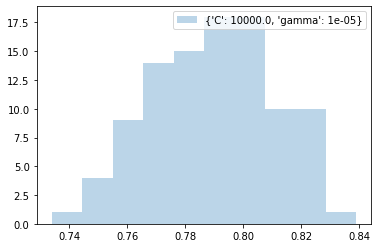

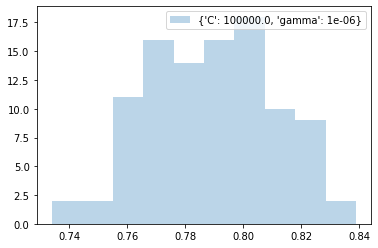

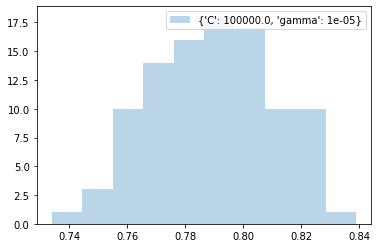

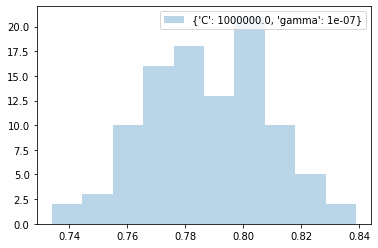

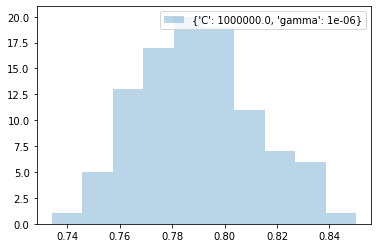

In [65]:
from matplotlib import pyplot as plt

for param in res[res.rank_test_score == 1].params:
    all_scores = []
    for i in range(100):
        train_d, test_d, train_l, test_l = train_test_split(data, label, test_size=0.3, random_state=i)
        clf = SVC(C=param['C'], gamma=param['gamma'])
        clf.fit(train_d, train_l)
        all_scores = np.append(all_scores, clf.score(test_d, test_l))
    
    plt.hist(all_scores, alpha=0.3, label=str(param))
    plt.legend()
    plt.show()

C=1e4, gamma=1e-5を採用

In [6]:
C=1e4
gamma=1e-5

In [66]:
# SVMと(SVMの)バギングでそれぞれモデル構築
models = {
    'SVM': SVC(C=C, gamma=gamma),
    'bagging': BaggingClassifier(SVC(C=C, gamma=gamma), n_estimators=100, random_state=0)
}
scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name, 'train_score')] = model.score(X_train, y_train)
    scores[(model_name, 'test_score')] = model.score(X_test, y_test)

In [67]:
pd.Series(scores).unstack()

,test_score,train_score
SVM,0.793722,0.786787
bagging,0.793722,0.786787


SVMではバギングを行っても正解率に差が出なかった  
### 2. ブースティング+SVM  
（参考）ブースティングはモデルが学習不足の傾向にあるときに有効

In [68]:
from sklearn.ensemble import AdaBoostClassifier

In [71]:
models = {
    'SVM': SVC(C=C, gamma=gamma),
    'AdaBoost': AdaBoostClassifier(SVC(C=C, gamma=gamma), random_state=0, algorithm='SAMME')
}

# モデル構築
scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name, 'train_score')] = model.score(X_train, y_train)
    scores[(model_name, 'test_score')] = model.score(X_test, y_test)
    
# 結果表示
pd.Series(scores).unstack()

,test_score,train_score
AdaBoost,0.654709,0.678679
SVM,0.793722,0.786787


ブースティングを行うとスコアが悪くなってしまった  
### 3. バギング+SVM(特徴量をランダムに抽出)

SKlearnのBaggingClassifierは弱識別器を作成するときデフォルトでデータセットの全特徴量を使う。  
ランダムフォレストでは全特徴量からいくつかをランダムで抽出して互いに相関の低い決定木を作成する。  
バギング+SVMで同様のことをやってみる。

In [17]:
# 弱識別器の作成に用いる特徴量の数
# 元データの特徴量が4つなので、2とする
max_features = 2

models = {
    'SVM': SVC(C=C, gamma=gamma),
    'bagging': BaggingClassifier(SVC(C=C, gamma=gamma), n_estimators=100, random_state=0, max_features=max_features)
}
scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name, 'train_score')] = model.score(X_train, y_train)
    scores[(model_name, 'test_score')] = model.score(X_test, y_test)

# 結果表示
pd.Series(scores).unstack()

,test_score,train_score
SVM,0.811659,0.780781
bagging,0.771300,0.786787


あまり変化はなかった...

考察  
バイアス-バリアンスの関係  
  
ランダムフォレストの弱識別器である決定木は、アルゴリズム上低バイアス-高バリアンス（過学習）のモデルになる。  
バギングで汎化性を高めると精度向上に繋がる。  
一方SVMは高バイアス-低バリアンスのモデル（と書かれていた）  
バギングでは精度に大きな変化はなかったが、なぜブースティングで精度が落ちてしまったのか…

### （追加）スケーリング（正規化）を行ったデータ予測

絶対値が小さい特徴量は他の特徴量に比べ予測への影響度が小さくなってしまう。それを防ぐため正規化する。  
学習データの各列に対して、平均値=0,標準偏差=1となるように数値変換する。

In [13]:
# 標準化を行うクラス
from sklearn.preprocessing import StandardScaler

# 標準化処理
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# バギング+SVMでモデル構築
max_features = 2

models = {
    'SVM': SVC(C=C, gamma=gamma),
    'bagging': BaggingClassifier(SVC(C=C, gamma=gamma), n_estimators=100, random_state=0, max_features=max_features)
}
scores = {}
for model_name, model in models.items():
    model.fit(X_train_std, y_train)
    scores[(model_name, 'train_score(scaled)')] = model.score(X_train_std, y_train)
    scores[(model_name, 'test_score(scaled)')] = model.score(X_test_std, y_test)
    model.fit(X_train, y_train)
    scores[(model_name, 'train_score')] = model.score(X_train, y_train)
    scores[(model_name, 'test_score')] = model.score(X_test, y_test)

# 結果表示
pd.Series(scores).unstack()

,test_score,test_score(scaled),train_score,train_score(scaled)
SVM,0.811659,0.811659,0.780781,0.777778
bagging,0.771300,0.775785,0.786787,0.783784


↓正規化前と後のデータ

In [16]:
X_train.head()

,Pclass,Sex,Fare,Embarked
36,3,0,7.2292,2.0
246,3,1,7.7750,0.0
558,1,1,79.6500,0.0
702,3,1,14.4542,2.0
465,3,0,7.0500,0.0


In [11]:
pd.DataFrame(X_train_std).head()

,0,1,2,3
0,0.824841,-0.743268,-0.490027,1.939227
1,0.824841,1.345409,-0.479344,-0.580822
2,-1.600519,1.345409,0.927436,-0.580822
3,0.824841,1.345409,-0.348615,1.939227
4,0.824841,-0.743268,-0.493534,-0.580822
